# Random Forest Algorithm

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)

In [2]:
problem_types = ['regression','classification'] #regression or classification
input_types = ['1_filter','genetic_algorithm'] #reduced features: 1_filter, genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254


In [3]:
def read_file(problem_type, input_file):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.

    Returns:
        tuple:
            - X (pd.DataFrame): Original feature DataFrame.
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    # Load the input feature file
    X = pd.read_csv(input_file)

    # Load the target data file based on the problem type
    if problem_type == 'regression':
        # For regression, retrieve '-logIC50' as the target column
        target = pd.read_csv('../../3_train_test_split/descriptors_all.csv')[['Molecule ChEMBL ID', '-logIC50']]
    elif problem_type == 'classification':
        # For classification, retrieve 'Potency' as the target column
        target = pd.read_csv('../../3_train_test_split/descriptors_all.csv')[['Molecule ChEMBL ID', 'Potency']]
    else:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    # Merge target data with the feature file based on 'Molecule ChEMBL ID'
    target = pd.merge(target, X[['Molecule ChEMBL ID']], on='Molecule ChEMBL ID')

    # Return the original feature DataFrame, indexed feature DataFrame, and target values
    return X, X.set_index('Molecule ChEMBL ID'), target.set_index('Molecule ChEMBL ID').squeeze()


In [4]:
def run_random_forest(problem_type, input_type, seed=42):
    """
    Run Random Forest algorithm for regression or classification with 5-fold cross-validation and hyperparameter optimization.
    Also plots data distribution for each fold.

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Directory of input feature reduction scheme (e.g., '1_filter').
        seed (int): Random seed for reproducibility.

    Returns:
        dict: Best model, test predictions, evaluation metrics, and test dataset.
    """
    base_dir = f"../../4_feature_selection/{input_type}/"
    # File paths
    if input_type == 'genetic_algorithm':
        base_dir = base_dir + "random_forest/"
    elif (input_type == "PCA") or (input_type == "PCA"):
        base_dir = base_dir + "pre_1_filter/" + "reg" if problem_type == "regression" else "class"

    problem = "reg" if problem_type == "regression" else "class"
    train_files = sorted([f for f in os.listdir(base_dir) if f.startswith(f"train_{problem}")])
    val_files = sorted([f for f in os.listdir(base_dir) if f.startswith(f"val_{problem}")])
    test_file = os.path.join(base_dir, f"test_{problem}.csv")
    
    # Load test dataset
    test_df, X_test, y_test = read_file(problem_type, test_file)

    # Initialize hyperparameter distribution for RandomizedSearchCV
    param_distributions = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
    }

    # # Initialize hyperparameter distribution for RandomizedSearchCV
    # param_distributions = {
    #     'n_estimators': [100],
    #     'max_depth': [10],
    #     'min_samples_split': [2],
    #     'min_samples_leaf': [1],
    #     'max_features': ['sqrt'],
    #     'bootstrap': [True],
    # }
    
    # Initialize model
    if problem_type == "regression":
        model = RandomForestRegressor(random_state=seed)
        scoring = make_scorer(mean_squared_error, greater_is_better=False)
    elif problem_type == "classification":
        model = RandomForestClassifier(random_state=seed, class_weight="balanced")  # Handle class imbalance
        scoring = "accuracy"  # Use default accuracy or optionally "f1_weighted"
    else:
        raise ValueError("Invalid problem_type. Choose 'regression' or 'classification'.")

    # Perform 5-fold cross-validation
    print(f"Running 5-fold cross-validation for {problem_type}...")
    fold_metrics = []
    best_models = []

    for fold in range(1, 6):
        # Load train and validation files for the current fold
        train_file = os.path.join(base_dir, f"train_{problem}_{fold}.csv")
        val_file = os.path.join(base_dir, f"val_{problem}_{fold}.csv")

        # Load training and validation data
        train_df, X_train, y_train = read_file(problem_type, train_file)
        val_df, X_val, y_val = read_file(problem_type, val_file)

        # # Plot data distribution for the current fold
        # plt.figure(figsize=(12, 6))
        
        # if problem_type == "regression":
        #     # Plot IC50 distribution for regression
        #     sns.histplot(y_train, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
        #     sns.histplot(y_val, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
        #     plt.xlabel("-log(IC50)")
        #     plt.ylabel("Count")
        #     plt.title(f"Data Distribution for Fold {fold} (Regression)")
        # else:
        #     # Plot class distribution for classification
        #     sns.countplot(x=y_train, label="Train", color="blue", alpha=0.7)
        #     sns.countplot(x=y_val, label="Validation", color="orange", alpha=0.7)
        #     plt.xlabel("Class")
        #     plt.ylabel("Count")
        #     plt.title(f"Data Distribution for Fold {fold} (Classification)")

        # plt.legend(["Train", "Validation"])
        # plt.savefig(f"data_distribution_fold_{fold}_{problem_type}.png", dpi=150)
        # plt.show()

        # Hyperparameter optimization using RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=50,  # Number of random parameter combinations to try
            scoring=scoring,  # Use 'f1_weighted' for multiclass tasks
            cv=3,  # Inner cross-validation
            n_jobs=-1,  # Use all available CPU cores
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)

        # Evaluate the best model on validation data
        best_model = random_search.best_estimator_
        best_models.append(best_model)

        y_val_pred = best_model.predict(X_val)
        if problem_type == "regression":
            metric = mean_squared_error(y_val, y_val_pred)
        else:
            metric = accuracy_score(y_val, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    # Average metric across folds
    avg_metric = np.mean(fold_metrics)
    print(f"Average Cross-Validation Metric: {avg_metric:.4f}")

    # Evaluate the best model on the test set
    if problem_type == "regression":
        final_model = best_models[np.argmin(fold_metrics)]  # Best model with lowest MSE
        test_metric = mean_squared_error(y_test, final_model.predict(X_test))
        print(f"Test MSE: {test_metric:.4f}")
    else:
        final_model = best_models[np.argmax(fold_metrics)]  # Best model with highest accuracy
        test_metric = accuracy_score(y_test, final_model.predict(X_test))
        print(f"Test Accuracy: {test_metric:.4f}")

    return {
        'best_model': final_model,
        'test_predictions': final_model.predict(X_test),
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test
    }

In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type="random_forest"):
    """
    Evaluate the model, create plots, and save performance summary and predictions.

    Parameters:
        final_model: Trained Random Forest model.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): True target values for the test set.
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme used.
        model_type (str): Model type (default is 'random forest').

    Returns:
        None
    """
    # Generate file prefix based on naming convention
    file_prefix = f"{model_type}_{problem_type}_{input_type}"

    # Predictions
    y_pred = final_model.predict(X_test)

    # Evaluate based on problem type
    if problem_type == "regression":
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "score": mse
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Predicted vs Target
        plt.figure(figsize=(6, 6), dpi=150)
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs Target")
        plt.savefig(f"{file_prefix}_predicted_vs_target.png")
        plt.show()

        # Plot Residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 6), dpi=150)
        plt.scatter(y_test, residuals, alpha=0.7)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Residuals")
        plt.title("Residual Plot")
        plt.savefig(f"{file_prefix}_residuals.png")
        plt.show()

    elif problem_type == "classification":
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": y_test,
            "Predicted Potency": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()

        # Plot ROC Curve for each class
        y_proba = final_model.predict_proba(X_test)
        plt.figure(figsize=(8, 6), dpi=150)
        for i, class_label in enumerate(final_model.classes_):
            fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="red", linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (One-vs-Rest)")
        plt.legend()
        plt.savefig(f"{file_prefix}_roc_curve.png")
        plt.show()

## Train and Evaluate the Model

Training Random Forest model for regression using 1_filter features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 1 - Best Model Metric: 9.1558
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 2 - Best Model Metric: 8.2323
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 3 - Best Model Metric: 9.2367
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 4 - Best Model Metric: 11.3842
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 5 - Best Model Metric: 8.1534
Average Cross-Validation Metric: 9.2325
Test MSE: 10.3124
Evaluating the model...


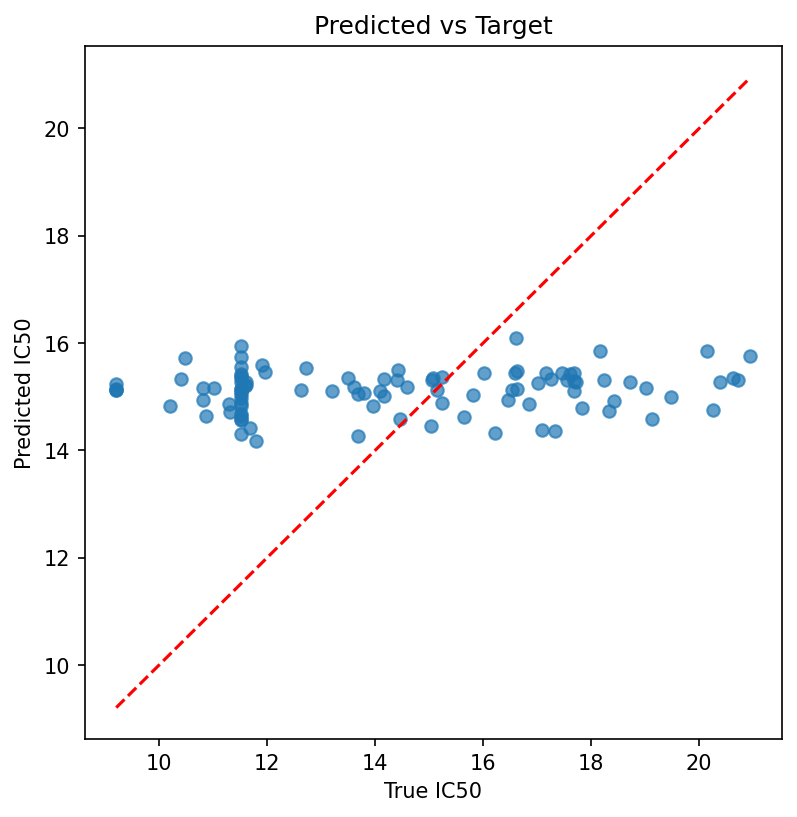

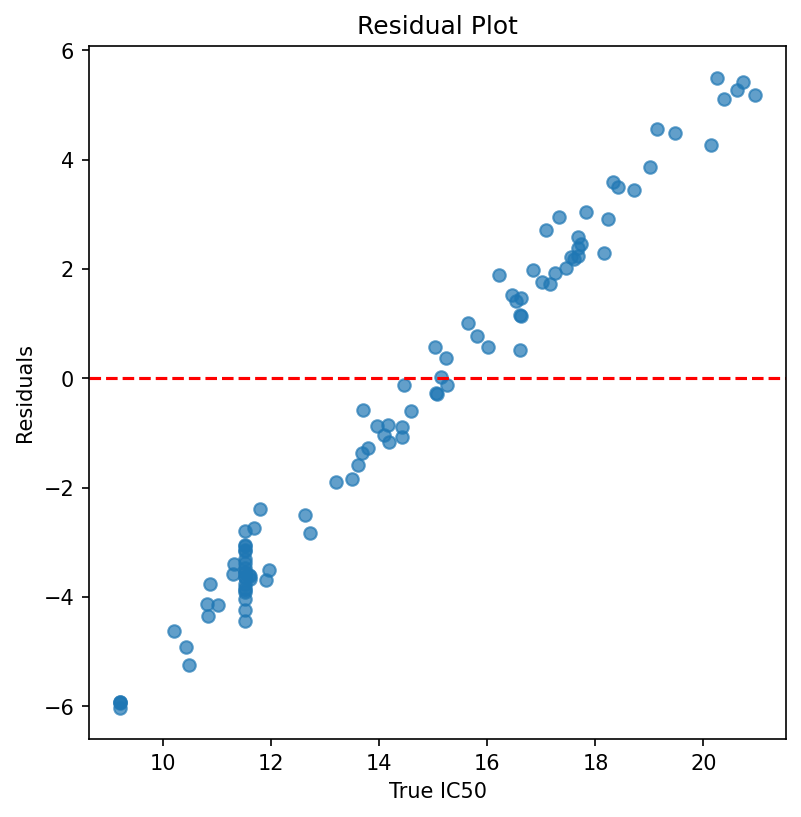

Training and evaluation complete
Training Random Forest model for regression using genetic_algorithm features...


KeyError: "None of [Index(['Molecule ChEMBL ID'], dtype='object')] are in the [columns]"

In [6]:
for problem_type in problem_types:
    for input_type in input_types:
        print(f"Training Random Forest model for {problem_type} using {input_type} features...")
        results = run_random_forest(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
        
        # Evaluate the model
        print(f"Evaluating the model...")
        evaluate_model(final_model, X_test, y_test, problem_type, input_type, "random_forest")
        
        print("Training and evaluation complete")


In [8]:
# Current directory containing train*, test*, and val* CSV files
current_dir = os.getcwd()

# Path to the directory containing the corresponding files
source_dir = os.path.abspath(os.path.join(current_dir, '../../3_train_test_split'))

# Iterate over all files in the current directory
for folder_name in os.listdir(current_dir):
    folder_path = os.path.join(current_dir, folder_name)
    
    # Ensure we're only processing directories
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.startswith(("train", "test", "val")) and file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)

                # Load the CSV file
                df = pd.read_csv(file_path)

                # Drop the first column
                df.drop(df.columns[0], axis=1, inplace=True)

                # Load the corresponding file from the source directory
                source_file_path = os.path.join(source_dir, file_name)
                if os.path.exists(source_file_path):
                    source_df = pd.read_csv(source_file_path)

                    # Insert the first column of the source file into the dataframe
                    df.insert(0, source_df.columns[0], source_df.iloc[:, 0])

                    # Save the updated dataframe to a new file
                    new_file_name = file_name.replace(".csv", "_new.csv")
                    new_file_path = os.path.join(folder_path, new_file_name)
                    df.to_csv(new_file_path, index=False)

                    print(f"Processed and saved: {new_file_path}")
                else:
                    print(f"Source file not found for: {file_name}")


Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/test_reg_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/train_class_5_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/train_class_4_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/train_reg_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/val_class_5_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_algorithm/xgboost/val_class_4_new.csv
Processed and saved: /Users/carmenmasri/Desktop/Erdos/QSAR/TRPM8-bootcamp-project/4_feature_selection/genetic_alg